<a href="https://colab.research.google.com/github/ferit-qc/lab3/blob/main/lab3_qft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3. - Implementation of Quantum Fourier Transformation, Phase Estimation and Shor's Algorithm

## Useful learning resources and links:
* [Quantum computing documentation](https://docs.quantum.ibm.com/)
* [Qiskit documentation](https://www.ibm.com/quantum/qiskit)
* [IBM Quantum Composer](https://quantum.ibm.com/composer)


In [170]:
pip install qiskit qiskit-ibm-runtime

In [171]:
pip install qiskit qiskit-aer

In [172]:
pip install matplotlib

In [173]:
pip install pylatexenc

In [174]:
from qiskit import *   # Imports core Qiskit classes (QuantumCircuit, transpile, etc.)
from qiskit_aer.aerprovider import AerSimulator # Provides access to the local quantum circuit simulator
from qiskit.visualization import plot_histogram # Enables visualization of measurement results
import matplotlib.pyplot as plt # Standard Python plotting library
from IPython.display import display # Allows rich display of plots in Jupyter notebooks
from IPython.display import Image
from IPython.core.display import HTML
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
import numpy as np
from numpy import pi

## 1. Quantum Fourier Transformation

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation.

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle$ according to the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:

$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$

Or the unitary matrix:

$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$

The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states $|0\rangle$ and $|1\rangle$ to the X-basis states $|{+}\rangle$ and $|{-}\rangle$. In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis. The QFT is simply the function that transforms between these bases.

$$
|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

(We often note states in the Fourier basis using the tilde (~)).

## 1.1 Counting in the Fourier basis: <a id="counting-fourier"></a>

In the computational basis, we store numbers in binary using the states $|0\rangle$ and $|1\rangle$:

![zbasis-counting.gif](<https://media-hosting.imagekit.io/68065a67cd7a41e6/zbasis-counting.gif?Expires=1837948674&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=0ncttX4FiLLhwKJRfpWvlVwgUVADzRFcuJ0bSywzclYrwdI~4N3GAZSVxlUlQiKRPT-mAKP2NGIJ2IcswMGGs3ZDaPTgtWjHURHugCA3y7S8dp1JZQXw4MxQ-vPbnDyWFwNLH-PK3scvOFstzo-eOjI5khs0hmlp9vG4SDITAtFqtfSrbNObDkQ72n6T0XifB3S0IN~Lx3I72GvRQqIOb~Ztm0~tPFbgWxCCiluMlQspREJUdlvoF7Nufp0AZ~zNzV29bgcbjN4Kb-Wr3fpsB6YhyGuWvdFhPxs4lbAMOXR1g2BfYruIZZD8HbGOH9d8BXN19f2TkRcTixrtlLvDLA__>)

Note the frequency with which the different qubits change; the leftmost qubit flips with every increment in the number, the next with every 2 increments, the third with every 4 increments, and so on. In the Fourier basis, we store numbers using different rotations around the Z-axis:

![fourierbasis-counting.gif](<https://media-hosting.imagekit.io/83f86d38d370473c/fourierbasis-counting.gif?Expires=1837948748&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=iiqtMDAdRpNLFARNokrn34F5Cp6NwaA6fmGwYgFntkB5Yw4aVlKwoUdccpoRRYjEhX3EcrgKCDcSfDyKj2wsgu5e0JNALeS9WInAGOuPOvHkuMymSgOTOu5pi9NIauelLdNFYg4zzoZel7j4Mr2dFX-LozArhWPqldPIOPRcBFMqZGljSmLBMEjqkV-x0P992IyWoU3Ch3XsYEJqZES88XYlfIiiS2zbyostuBKPn0aUDBMsKS9c2XsrR2qCzdLt0QtypUlzHonYIutf1MM0QShnGGi6lwFfCjjEdb2Qa0ommbuCAuvC5SDfQXJQj6akRe4oRiggLjPYe27WXHRdhg__>)

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis. In the state $|\widetilde{0}\rangle$, all qubits are in the state $|{+}\rangle$. As seen in the example above, to encode the state $|\widetilde{5}\rangle$ on 4 qubits, we rotated the leftmost qubit by $\tfrac{5}{2^n} = \tfrac{5}{16}$ full turns ($\tfrac{5}{16}\times 2\pi$ radians). The next qubit is turned double this ($\tfrac{10}{16}\times 2\pi$ radians, or $10/16$ full turns), this angle is then doubled for the qubit after, and so on.

Again, note the frequency with which each qubit changes. The leftmost qubit (`qubit 0`) in this case has the lowest frequency, and the rightmost the highest.



## 1.3. Example 1: 1-qubit QFT

Consider how the QFT operator as defined above acts on a single qubit state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$. In this case, $x_0 = \alpha$, $x_1 = \beta$, and $N = 2$. Then,

$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times0}{2}\right) + \beta \exp\left(2\pi i\frac{1\times0}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$

and

$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times1}{2}\right) + \beta \exp\left(2\pi i\frac{1\times1}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$

such that the final result is the state

$$U_{QFT}\vert\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle$$

This operation is exactly the result of applying the Hadamard operator ($H$) on the qubit:

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

If we apply the $H$ operator to the state $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$, we obtain the new state:

$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$

Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state.

## 1.4. The Quantum Fourier tranfsorm

So what does the quantum Fourier transform look like for larger $N$? Let's derive a transformation for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit. This maths is here for those that find it useful, if you struggle with it then don’t worry; as long as you understand the intuition in section 2 then you can continue straight to the next section.

$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$

This is a mathematical description of the animation we saw in the intuition section:

![fourierbasis-counting (1).gif](<https://media-hosting.imagekit.io/c58e99b5b71544bc/fourierbasis-counting%20(1).gif?Expires=1837948843&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=Xupced8iisqH5G2jL9hMiLifnpgOI4bgY8dhwwTR5pop1tx~VMOgA3fKQVi5qEpdC-1ycwU2NZam5Svg-WHk5hT67fnqb3Fv7m5c4KREB7DYNac~tuLqkTGtP-GuvXok3M9GWxaRw04nsnogZwKkxGoMOL~pKeaPwa~Whq2y6g8TTpU1jLcT3nyLeybKkfblA8SUuZj8fDzTjGKuWD~XNuMKwFY7yl1~6TsxM7WN2L3C-irFqqSl3SdavlSdTkAGHKeQhZpubvMSZfZob3c4RM7ohT6GZh83K705KgMpZRr2nSHmE8eTdqDlpqB2LNtCTIey8Solks7iTSCXVnvM1Q__>)

# New Section

## 1.5. The Circuit that Implements the QFT

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. From the discussion in [Example 1](#example1) above, you have already seen that the action of $H$ on the single-qubit state $\vert x_k\rangle$ is

$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$

The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$

where

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on a two-qubit state $\vert x_l x_j\rangle$ where the first qubit is the control and the second is the target is given by

$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$

and

$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$

Given these two gates, a circuit that implements [an n-qubit QFT](#qfteqn) is shown below.

![qft.png](<https://media-hosting.imagekit.io/60e330e6afca4496/qft.png?Expires=1837948899&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=jNjsZ3I9VyyDheqQo-JR5iPEDpKVwJtyDlkp5Fc7hQfK83hHvgwXLhteIGRahsa4o-yMiLEqZNMOshin9zby2m9w9i-BUnQQupgLxdtleYQDsMsttCW70HqSnut382nXJCUqdLJJRNMcvXRd6RXgWMqrLNoYuhJnqrFm9Sfh8i4c8zCe50smKWsD1EFfYNphIBbGPXtB4PHasSvcx~VhnXbTzQ8OwHO~3DVSepfO6EjQ9L8yby6cu2aVtywENLemMyjC-~4JfR8DouDZpP-QGYEMxC4bESS~xFMUvno97PFVJIJdj3i7B8IlF~dTunfVCi1icE1lG01cYQQ4WTkW4g__>)

The circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$.

<ol>
<li> After the first Hadamard gate on qubit 1, the state is transformed from the input state to

$$
H_1\vert x_1x_2\ldots x_n\rangle =
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x_n +
\frac{2\pi i}{2^{n-1}}x_{n-1} +
\ldots +
\frac{2\pi i}{2^2}x_2 +
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{n-1}}x
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{2}}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{1}}x
\right)
\vert1\rangle\right]
$$

which is exactly the QFT of the input state as derived <a href="#qfteqn">above</a> with the caveat that the order of the qubits is reversed in the output state.
</ol>

## 1.6. Example 2: 3-qubit QFT

The steps to creating the circuit for $\vert y_3y_2y_1\rangle = QFT_8\vert x_3x_2x_1\rangle$ would be:

<ol>
<li> Apply a Hadamard gate to $\vert x_1 \rangle$

$$
|\psi_1\rangle =
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(\frac{2\pi i}{2}x_1\right)
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_1\rangle$ depending on $\vert x_2\rangle$

$$
|\psi_2\rangle =
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
$$

<li> Apply a $UROT_3$ gate to $\vert x_1\rangle$ depending on $\vert x_3\rangle$

$$
|\psi_3\rangle =
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_2 \rangle$

$$
|\psi_4\rangle =
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2}x_2
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
$$

<li> Apply a $UROT_2$ gate to $\vert x_2\rangle$ depending on $\vert x_3\rangle$

$$
|\psi_5\rangle =
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
$$

<li> Apply a Hadamard gate to $\vert x_3\rangle$

$$
|\psi_6\rangle =
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2}x_3
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
$$


<li> Keep in mind the reverse order of the output state relative to the desired QFT. Therefore, we must reverse the order of the qubits (in this case swap $y_1$ and $y_3$).

The example above demonstrates a very useful form of the QFT for $N=2^n$. Note that only the last qubit depends on the values of all the other input qubits and each further bit depends less and less on the input qubits. This becomes important in physical implementations of the QFT, where nearest-neighbor couplings are easier to achieve than distant couplings between qubits.

Additionally, as the QFT circuit becomes large, an increasing amount of time is spent doing increasingly slight rotations. It turns out that we can ignore rotations below a certain threshold and still get decent results, this is known as the approximate QFT. This is also important in physical implementations, as reducing the number of operations can greatly reduce decoherence and potential gate errors.  

## 1.7. Qiskit Implementation

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined as

$$
CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### Example on 3 Qubits <a id="threeqft"></a>

It is useful to work out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. First, we must define our quantum circuit:

In [175]:
qc = QuantumCircuit(3)

It is useful to work out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. First, we must define our quantum circuit:

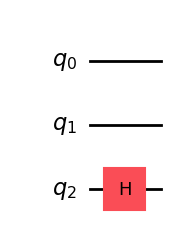

In [176]:
qc.h(2)
qc.draw(output = 'mpl')

Next, we want to turn this an extra quarter turn if qubit 1 is in the state $|1\rangle$:

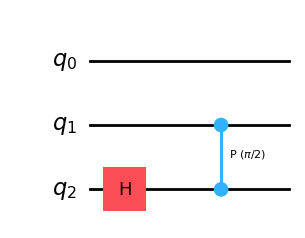

In [177]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw(output = 'mpl')

And another eighth turn if the least significant qubit (0) is $|1\rangle$:

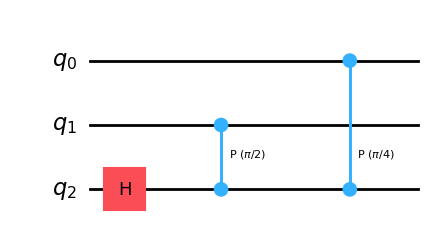

In [178]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw(output = 'mpl')

With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

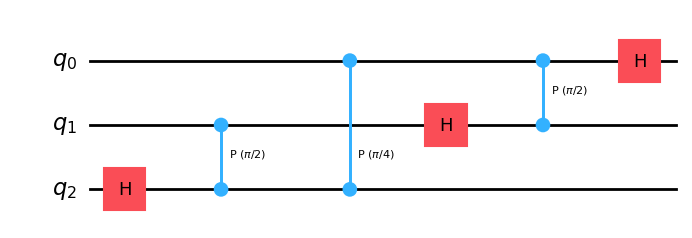

In [179]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw(output = 'mpl')

Finally we must swap the qubits 0 and 2 to complete the QFT:

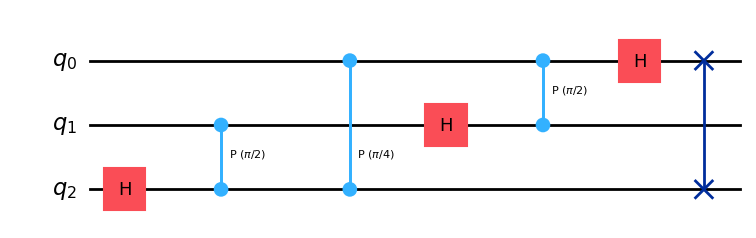

In [180]:
qc.swap(0,2)
qc.draw(output = 'mpl')

### 1.8. General QFT Function <a id="generalqft"></a>

We will now create a general circuit for the QFT in Qiskit. Creating large general circuits like this is really where Qiskit shines.

It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards; we will start off by creating the function that rotates our qubits correctly. Let’s start as we did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index):

In [181]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation:
        circuit.cp(pi/2**(n-qubit), qubit, n)

Let’s see how this looks:

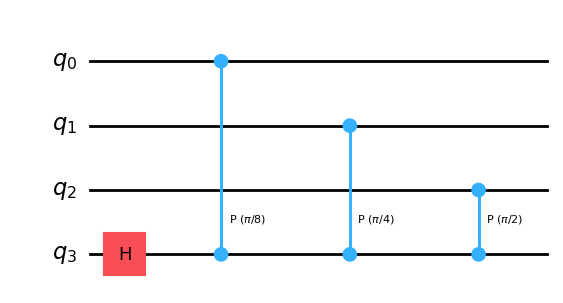

In [182]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw(output = 'mpl')

We can use the widget below to see how this circuit scales with the number of qubits in our circuit:

In [183]:
from qiskit import QuantumCircuit
from numpy import pi
from ipywidgets import interact, IntSlider

# QFT rotation subroutine
def qft_rotations(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi / 2**(n - qubit), qubit, n)
    qft_rotations(circuit, n)
    return circuit

# Full QFT circuit with swaps
def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# Display function (returns figure)
def display_qft(n):
    qc = qft_circuit(n)
    return qc.draw('mpl')  # RETURN the figure to make widget render it

# Interactive slider
interact(display_qft, n=IntSlider(min=2, max=6, step=1, value=3))


interactive(children=(IntSlider(value=3, description='n', max=6, min=2), Output()), _dom_classes=('widget-inte…

<function __main__.display_qft(n)>

Great! This is the first part of our QFT. Now we have correctly rotated the most significant qubit, we need to correctly rotate the second most significant qubit. Then we must deal with the third most significant, and so on. But why write more code? When we get to the end of our `qft_rotations()` function, we can use the same code to repeat the process on the next `n-1` qubits:

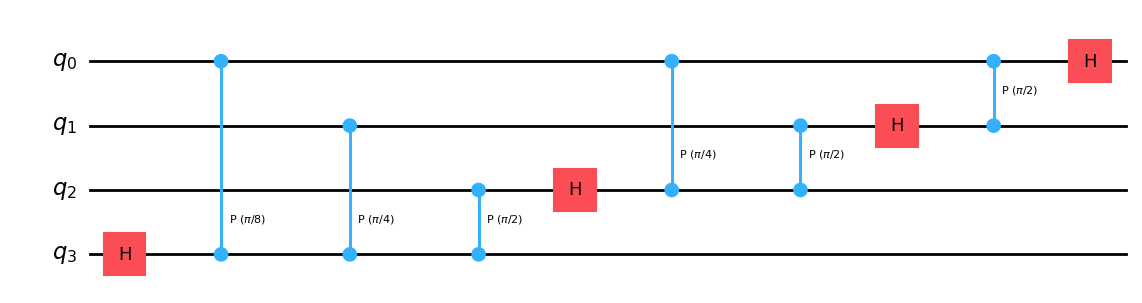

In [184]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw(output = 'mpl')

That was easy! Process in which a function calls itself directly or indirectly is called _recursion._ It can greatly simplify code. We can again see how this scales using the widget below:

In [185]:
from ipywidgets import interact, IntSlider

# Recursive QFT rotation logic (no swaps)
def qft_rotations(circuit, n):
    """Performs QFT rotations recursively (no swaps)"""
    if n == 0:
        return
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi / 2**(n - qubit), qubit, n)
    qft_rotations(circuit, n)

# Wrapper function: builds full QFT including swaps
def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# Display function for widget (returns circuit image)
def display_qft(n):
    qc = qft_circuit(n)
    return qc.draw('mpl')

# Create interactive widget (like scalable_circuit)
interact(display_qft, n=IntSlider(min=2, max=6, step=1, value=3))

interactive(children=(IntSlider(value=3, description='n', max=6, min=2), Output()), _dom_classes=('widget-inte…

<function __main__.display_qft(n)>

Finally, we need to add the swaps at the end of the QFT function to match the definition of the QFT. We will combine this into the final function `qft()`:

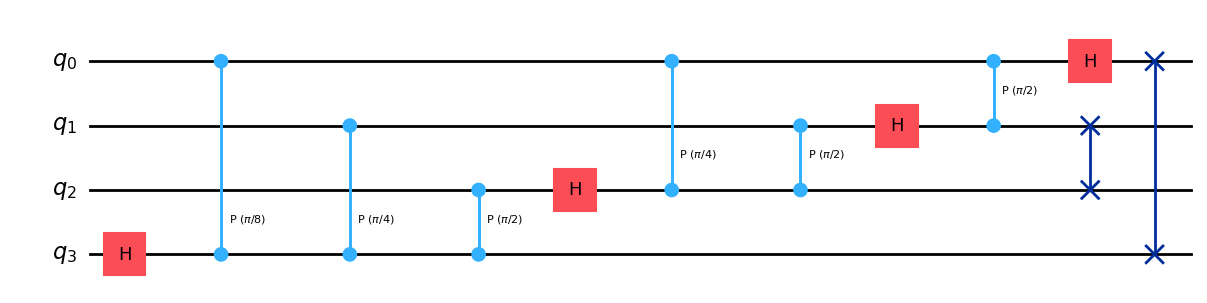

In [186]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw(output = 'mpl')

This is the generalised circuit for the quantum Fourier transform. We can again see how this scales using the widget below:

In [187]:
# Recursive QFT rotation logic (no swaps)
def qft_rotations(circuit, n):
    """Performs QFT rotations recursively (no swaps)"""
    if n == 0:
        return
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi / 2**(n - qubit), qubit, n)
    qft_rotations(circuit, n)

# Wrapper function: builds full QFT including swaps
def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

# Display function for widget (returns circuit image)
def display_qft(n):
    qc = qft_circuit(n)
    return qc.draw('mpl')

# Create interactive widget (like scalable_circuit)
interact(display_qft, n=IntSlider(min=2, max=6, step=1, value=3))

interactive(children=(IntSlider(value=3, description='n', max=6, min=2), Output()), _dom_classes=('widget-inte…

<function __main__.display_qft(n)>

We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. We can see the number 5 in binary is `101`:

In [188]:
bin(5)

'0b101'

(The `0b` just reminds us this is a binary number). Let's encode this into our qubits:

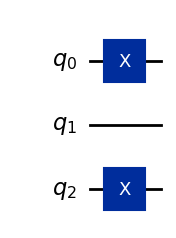

In [189]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw(output = 'mpl')

And let's check the qubit's states using the aer simulator:

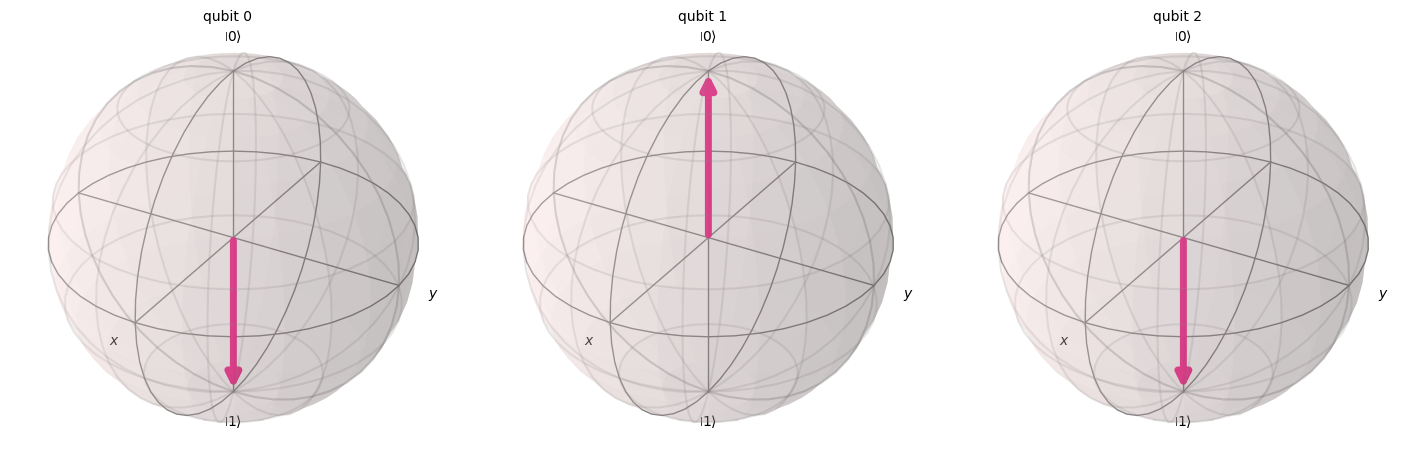

In [190]:
sim = AerSimulator()
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's use our QFT function and view the final state of our qubits:

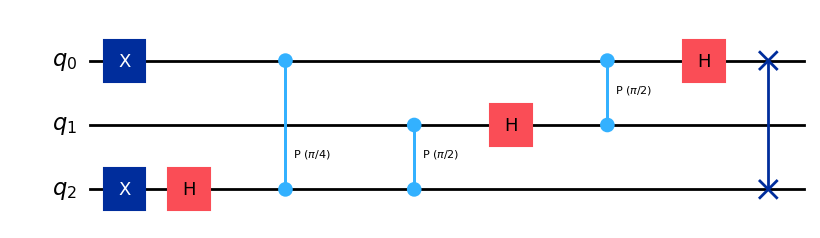

In [191]:
qft(qc,3)
qc.draw(output = 'mpl')

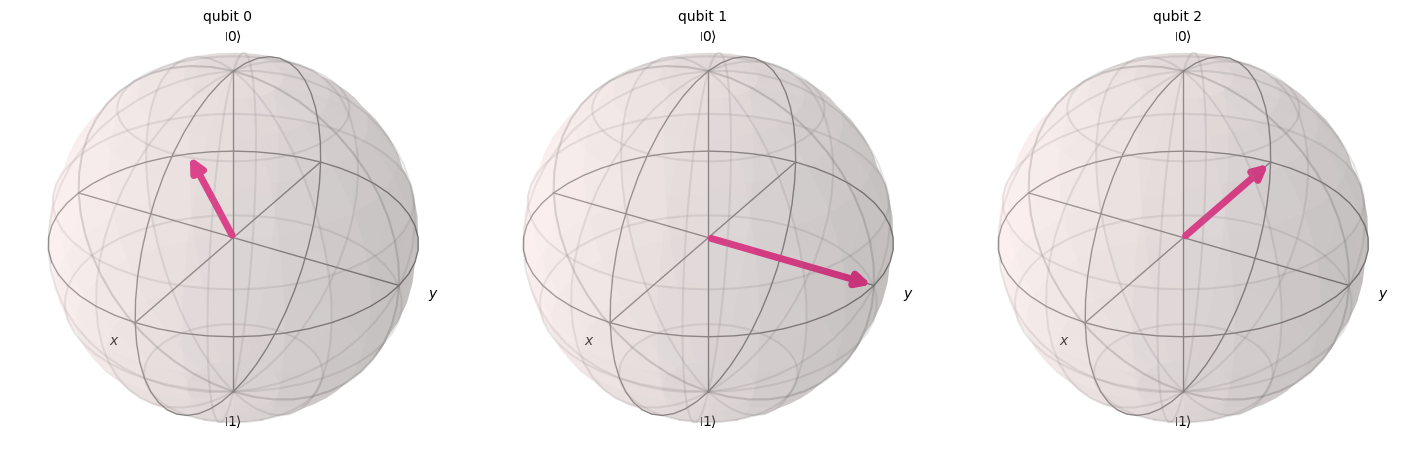

In [192]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

We can see out QFT function has worked correctly. Compared the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 has been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

## Tasks

1. The above implementation of QFT was tested by preparing the Fourier state $|\widetilde{5}\rangle$ for which $\text{QFT}^{\dagger}|\widetilde{5}\rangle = |101\rangle$. Try to find the state $|a\rangle$ such that $\text{QFT}^{\dagger}|a\rangle = |100\rangle$.
2. Find the state $|b\rangle$ such that $\text{QFT}^{\dagger}|b\rangle = |011\rangle$.

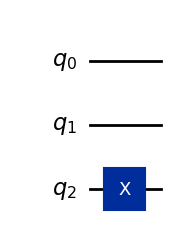

In [193]:
qc = QuantumCircuit(3)

qc.x(2)
qc.draw(output = 'mpl')

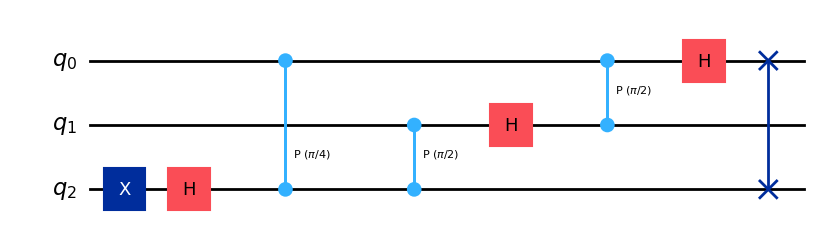

In [194]:
qft(qc,3)
qc.draw(output = 'mpl')

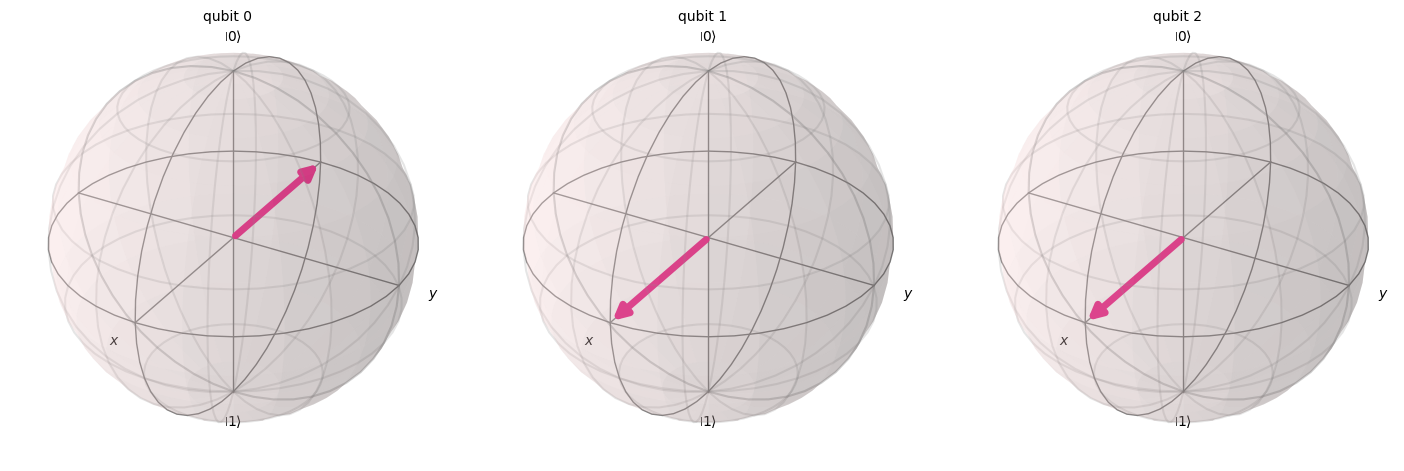

In [195]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

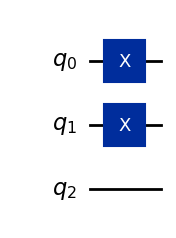

In [196]:
qc = QuantumCircuit(3)

qc.x(0)
qc.x(1)
qc.draw(output = 'mpl')

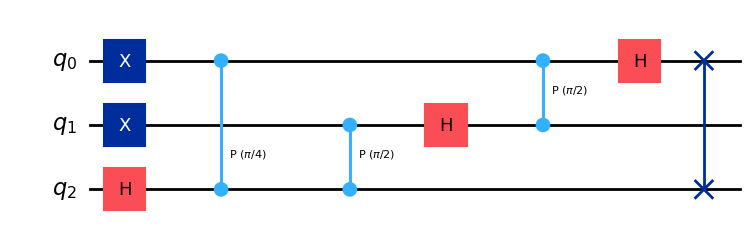

In [197]:
qft(qc,3)
qc.draw(output = 'mpl')

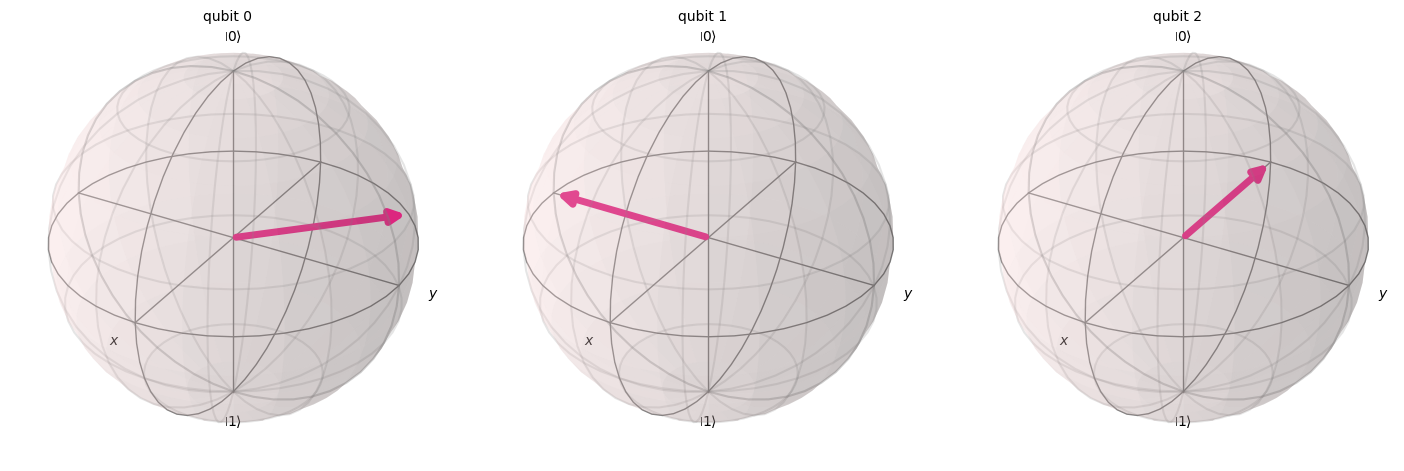

In [198]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

## 2. Quantum Phase Estimation



Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

The general quantum circuit for phase estimation is shown below. The top register contains $t$ 'counting' qubits, and the bottom contains qubits in the state $|\psi\rangle$:

![screenshot_1743351015101.png](<https://media-hosting.imagekit.io/1f5efd2de60e44ed/screenshot_1743351015101.png?Expires=1837959016&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=zcYG6USeLzRqBlTwZSGEM8b0xOb286Ef8db99ufFigTWciQIBOsLoTEo2~V0SzOFP7FYOusQHT5Pq3M9Wd1NsbXeFSEXwMAiRTrcIr00gqRj-7NgWxx6IBrOKhDX2sX0hRiNgmSEkCsqNZojiDSw-zfl45O4qGiuiZTxtGEdzTlpcm2wG1j8M5pNvlGHhPvQG3hFXQYO7LC-mIJEULKr2UWAPV5ojaOe8Qx-wCgHTSLwe6jguhYGU5gyB~xvYHItyFFlbxxwozqSIJTgAfkjWHs1lIfMmGkaVX8oDRFNPG4-C-sWoxUuDlltDnDbj4BrqkgpG~CRqYwPz0vkoKZXqw__>)


### 2.1 Intuition  
The quantum phase estimation algorithm uses phase kickback to write the phase of $U$ (in the Fourier basis) to the $t$ qubits in the counting register. We then use the inverse QFT to translate this from the Fourier basis into the computational basis, which we can measure.

We remember (from the QFT chapter) that in the Fourier basis the topmost qubit completes one full rotation when counting between $0$ and $2^t$. To count to a number, $x$ between $0$ and $2^t$, we rotate this qubit by $\tfrac{x}{2^t}$ around the z-axis. For the next qubit we rotate by $\tfrac{2x}{2^t}$, then $\tfrac{4x}{2^t}$ for the third qubit.

![screenshot_1743351041605.png](<https://media-hosting.imagekit.io/613463e35e7a44b1/screenshot_1743351041605.png?Expires=1837959041&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=VG7ZnglnUo2zxtA37Tv528UsRbXn6QAwTN86tlRRL3z7gKMTIsFg2hkFKBxPWzRW0RDiKCYWngpwsnBhFBH5urLNqgfIZu30eyAI-OckfxGW3THsSbarpS-2TKbbpd68HSraaIyRinQdV3ho2VxpHJjJwSQtQe3Us2tDZYBxGpsFMG2-0LXNbXdShVQjwDW1JAQtuR8vItwX7w9d3qheJthj1sRI7XW5zblV4i8Qz2fgE3OSPKjjXk6BJEVv7Axh1HHkCahRunFwMi603vkEFLEYt98~KNcgnEttEKXdXEMmdUBxaiOKVljXKVBH2WzaN3fak1MenSPL26qXadWyzg__>)

When we use a qubit to control the $U$-gate, the qubit will turn (due to kickback) proportionally to the phase $e^{2i\pi\theta}$. We can use successive $CU$-gates to repeat this rotation an appropriate number of times until we have encoded the phase theta as a number between $0$ and $2^t$ in the Fourier basis.

Then we simply use $QFT^\dagger$ to convert this into the computational basis.



### 2.2 Mathematical Foundation <a id='maths'></a>

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$:

$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$

ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register:

$$ |\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$

iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $CU$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means:


$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$


Applying all the $n$ controlled operations $CU^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

$$
\begin{aligned}
|\psi_{2}\rangle & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
$$

where $k$ denotes the integer representation of n-bit binary numbers.

iv. **Inverse Fourier Transform**: Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the auxiliary register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$

v. **Measurement**:
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability:



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$ [1].

## 2.3. Example: T-gate <a id='example_t_gate'></a>

Let’s take a gate we know well, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$



In this example we will use three qubits and obtain an _exact_ result (not an estimation!)

### 2.4 Creating the Circuit

Now, set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as the eigenstate of the unitary operator ($T$).

We initialize $\vert\psi\rangle = \vert1\rangle$ by applying an $X$ gate:

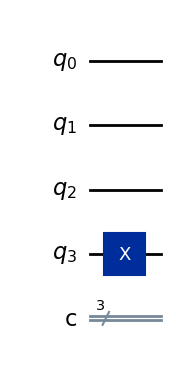

In [199]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw(output = 'mpl')

Next, we apply Hadamard gates to the counting qubits:

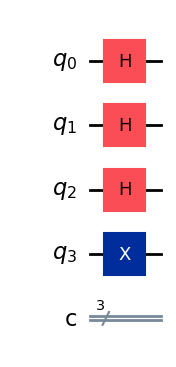

In [200]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw(output = 'mpl')

Next we perform the controlled unitary operations.

We'll use Qiskit's [`PhaseGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html) to create the $T$ operation. The phase gate does the transformation $P|1\rangle = e^{i\lambda}|1\rangle$, where $\lambda$ is the angle we provide. Since we want to implement $T$, which performs $T|1\rangle = e^{2\pi i \theta}|1\rangle$, we need to set $\lambda = \tfrac{2 \pi}{8} = \pi/4$.

Also remember that Qiskit orders its qubits the opposite way round to the circuit diagram in the overview.

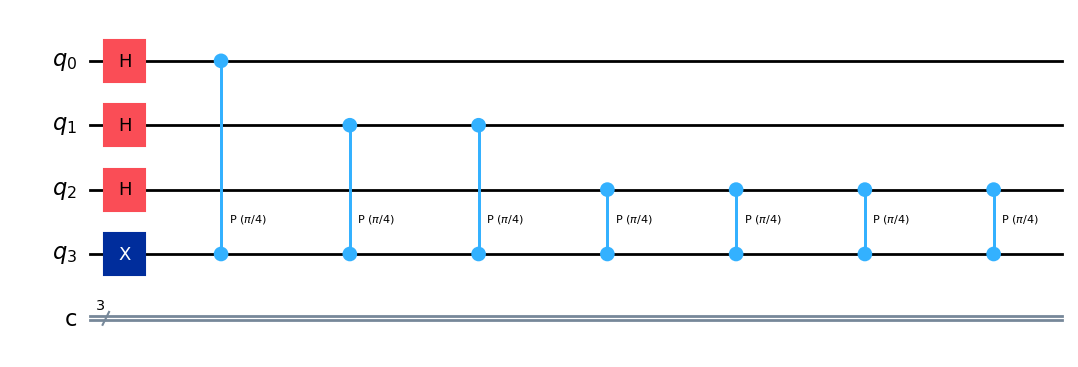

In [201]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # controlled-T
    repetitions *= 2
qpe.draw(output = 'mpl')

We apply the inverse quantum Fourier transformation to convert the state of the counting register, then measure the counting register:

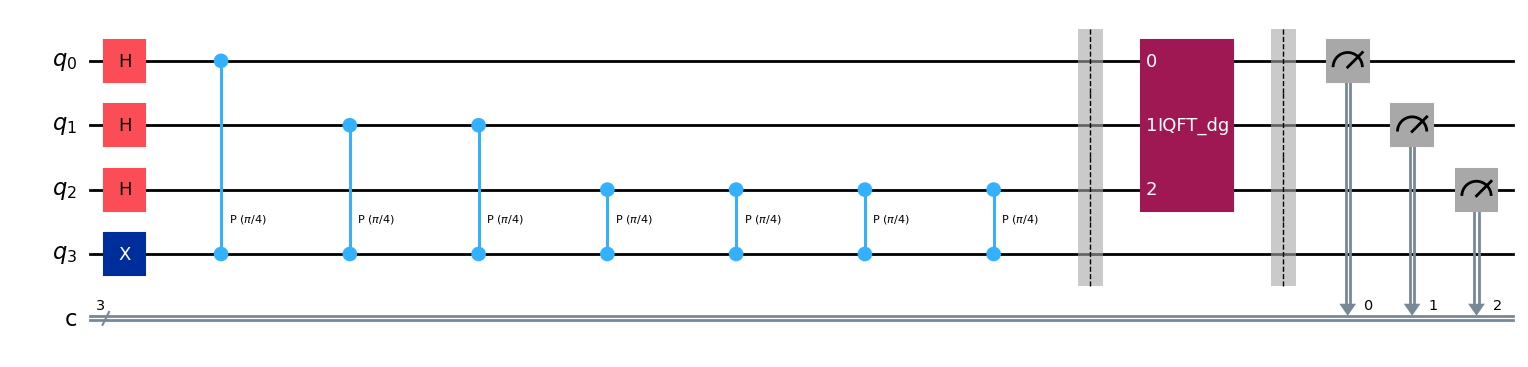

In [202]:
from qiskit.circuit.library import QFT
qpe.barrier()
# Apply inverse QFT
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw(output = 'mpl')

### 2.5. Visualization of Results


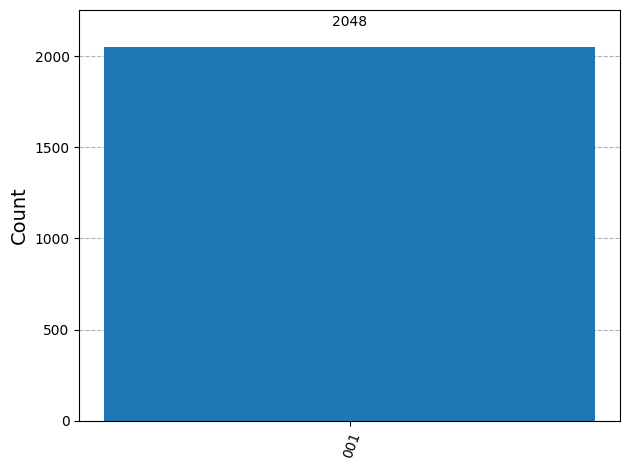

In [203]:
aer_sim = AerSimulator()
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (`001`) with certainty, which translates to the decimal: `1`. We now need to divide our result (`1`) by $2^n$ to get $\theta$:



$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$



This is exactly the result we expected!

## 2.6. Example: Getting More Precision: The Problem

Instead of a $T$-gate, let’s use a gate with $\theta = \frac{1}{3}$.

In the cell below, we set up our circuit as we did with the last example.

We'll use Qiskit's [`PhaseGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html) again, which does $P|1\rangle = e^{i\lambda}|1\rangle$. Since we want to implement $U|1\rangle = e^{2\pi i \tfrac{1}{3}}|1\rangle$, we need to set $\lambda = \tfrac{2 \pi}{3}$.

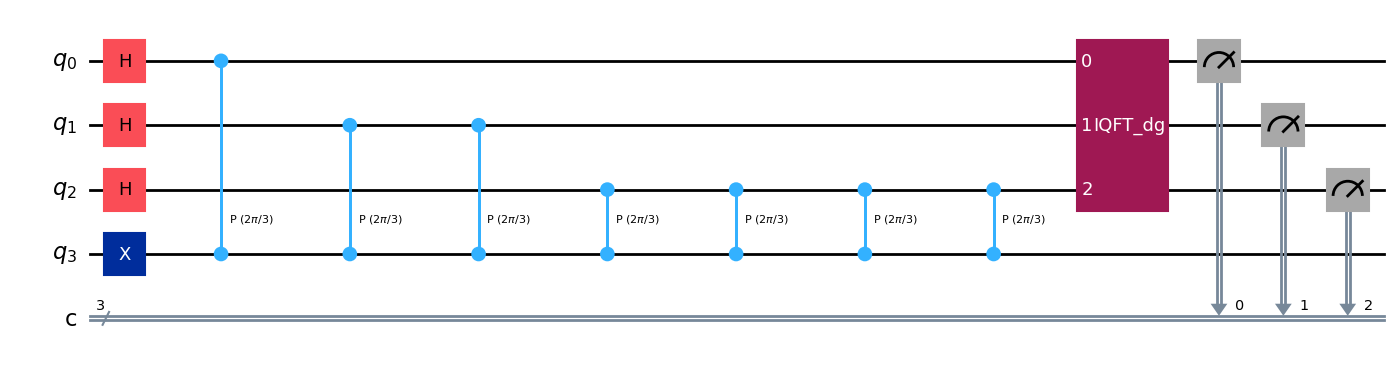

In [204]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw(output = 'mpl')

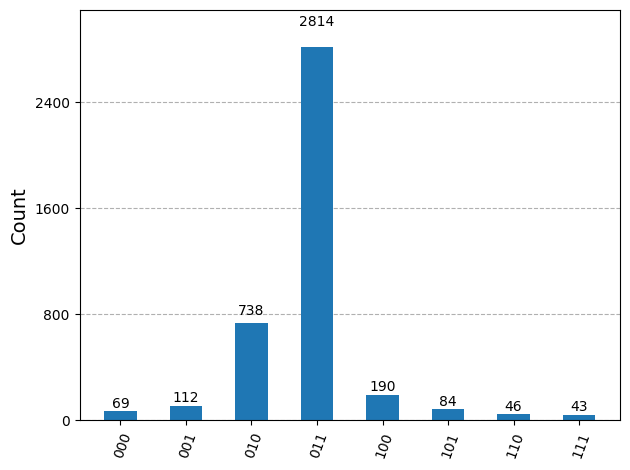

In [205]:
# Let's see the results!
aer_sim = AerSimulator()
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 0.3333\dots$, and we see our most likely results are `010(bin) = 2(dec)` and `011(bin) = 3(dec)`. These two results would tell us that $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

### 2.7. The Solution
To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

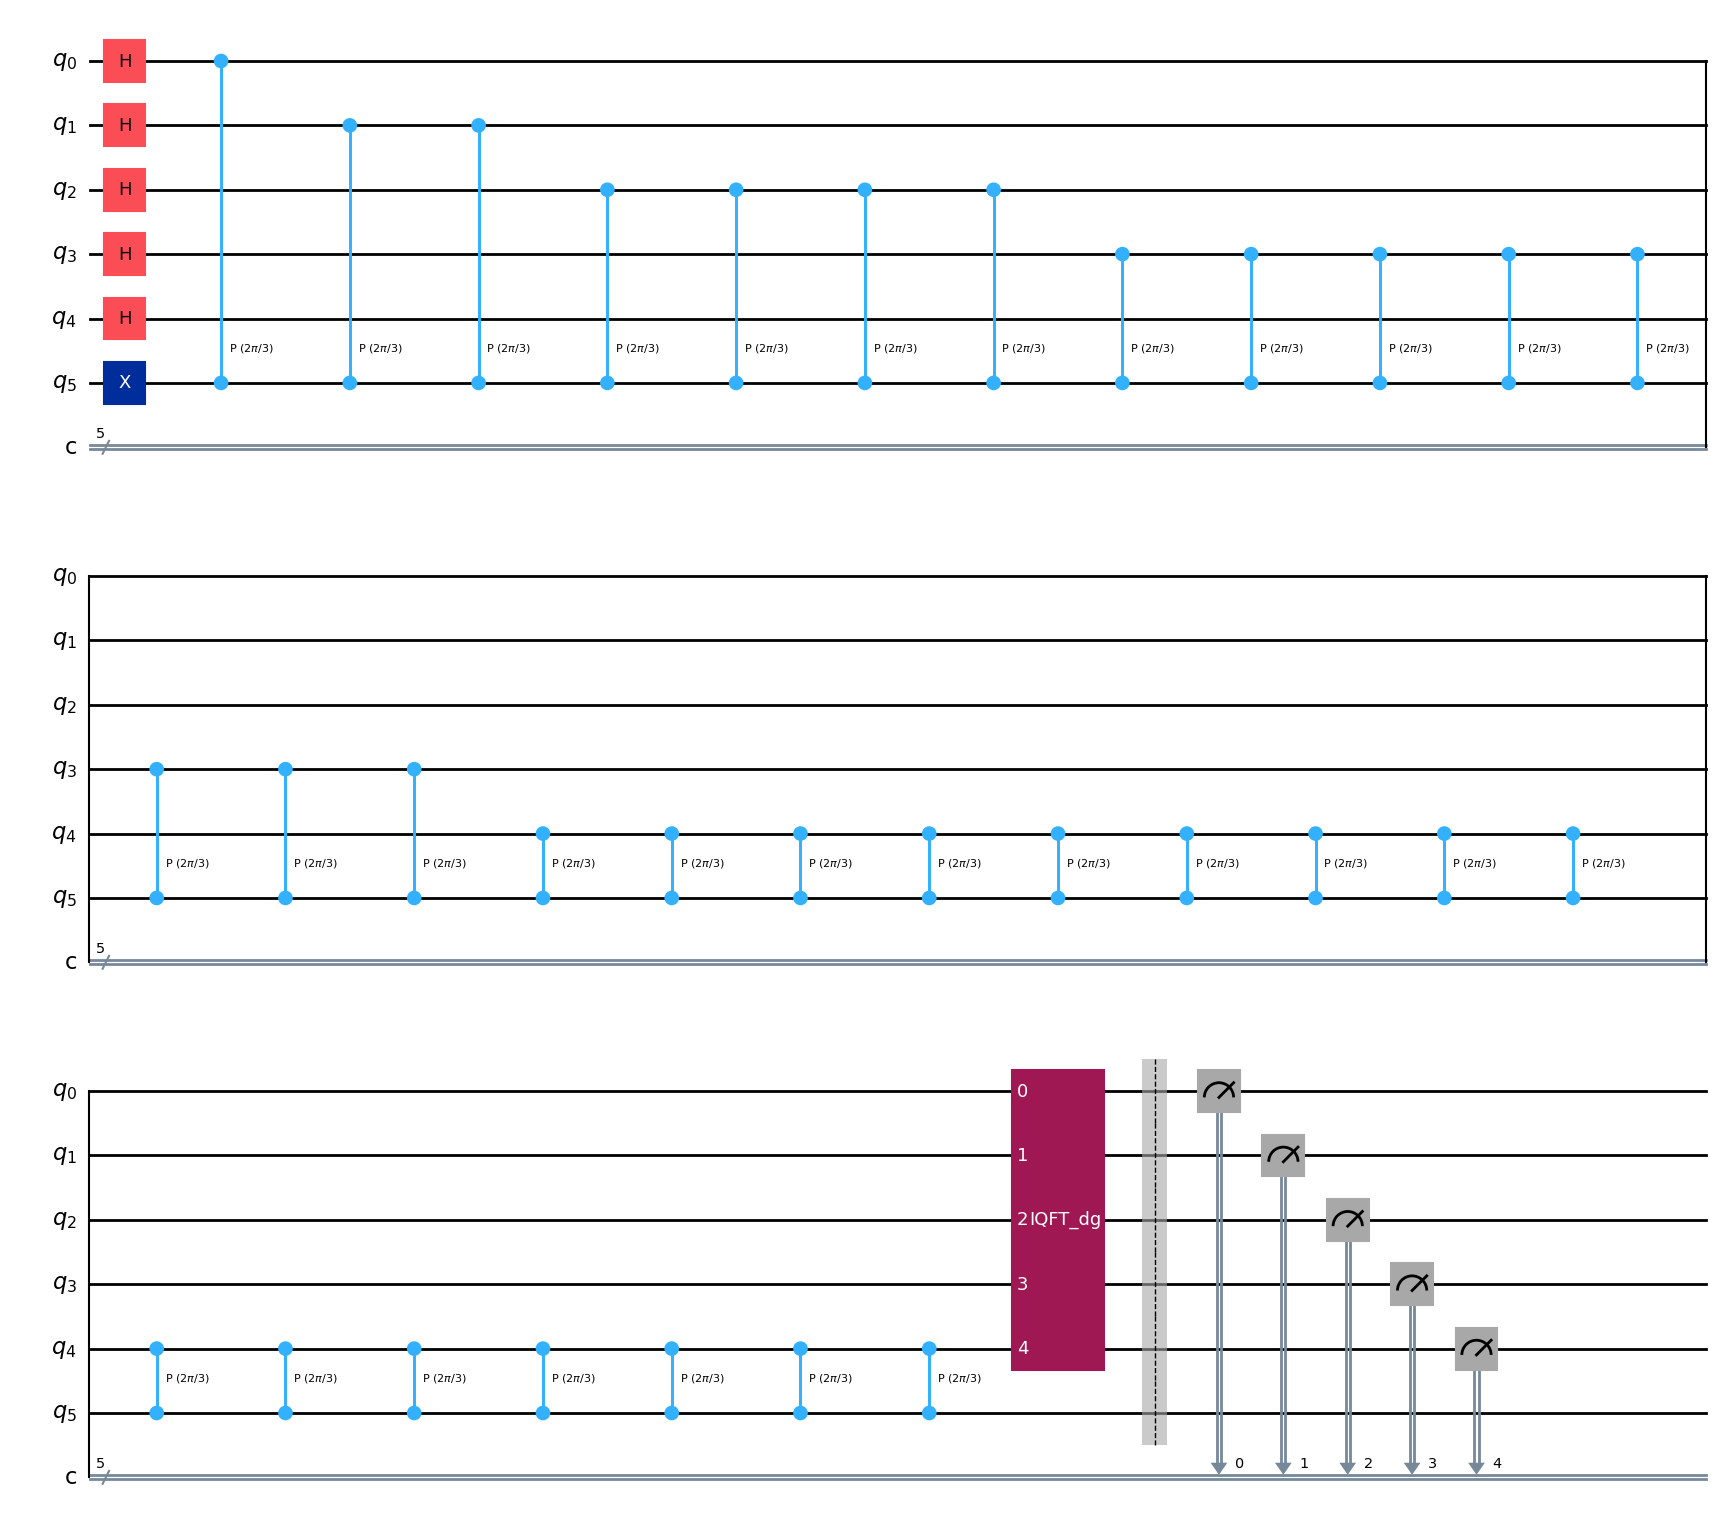

In [206]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qpe3 = qpe3.compose(QFT(5, inverse=True), range(5))

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw(output = 'mpl')

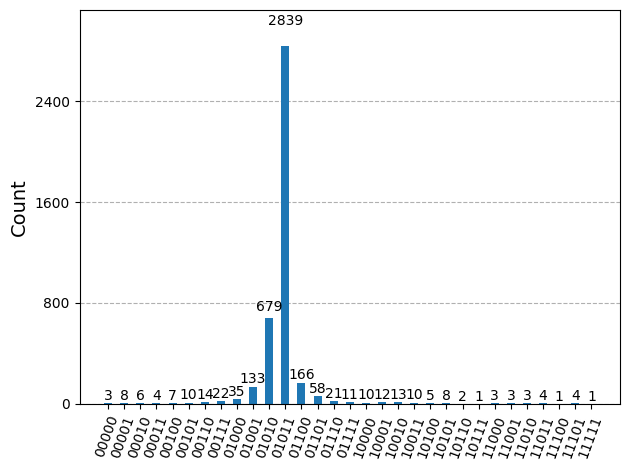

In [207]:
# Let's see the results!
aer_sim = AerSimulator()
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
results = aer_sim.run(t_qpe3, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

The two most likely measurements are now `01011` (decimal 11) and `01010` (decimal 10). Measuring these results would tell us $\theta$ is:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{  or  }\;\; \theta = \frac{10}{2^5} = 0.313
$$

These two results differ from $\frac{1}{3}$ by 3% and 6% respectively. A much better precision!

# 3. Shor's Algorithm

Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires greater-than-polynomial time to factor the product of two primes, the widely used cryptographic protocol, RSA, relies on factoring being impossible for large enough integers.

In this chapter we will focus on the quantum part of Shor’s algorithm, which actually solves the problem of _period finding_. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of $a^x\bmod N$ efficiently, then we can also efficiently factor. Since period finding is a worthy problem in its own right, we will first solve this, then discuss how this can be used to factor in section 5.

## 3. 1. The Problem: Period Finding

Let’s look at the periodic function:

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Reminder: Modulo &amp; Modular Arithmetic (Click here to expand)</summary>

The modulo operation (abbreviated to 'mod') simply means to find the remainder when dividing one number by another. For example:

$$ 17 \bmod 5 = 2 $$

Since $17 \div 5 = 3$ with remainder $2$. (i.e. $17 = (3\times 5) + 2$). In Python, the modulo operation is denoted through the <code>%</code> symbol.

This behaviour is used in <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">modular arithmetic</a>, where numbers 'wrap round' after reaching a certain value (the modulus). Using modular arithmetic, we could write:

$$ 17 = 2 \pmod 5$$

Note that here the $\pmod 5$ applies to the entire equation (since it's in parenthesis), unlike the equation above where it only applied to the left-hand side of the equation.
</details>

where $a$ and $N$ are positive integers, $a$ is less than $N$, and they have no common factors. The period, or order ($r$), is the smallest (non-zero) integer such that:

$$a^r \bmod N = 1 $$

We can see an example of this function plotted on the graph below. Note that the lines between points are to help see the periodicity and do not represent the intermediate values between the x-markers.

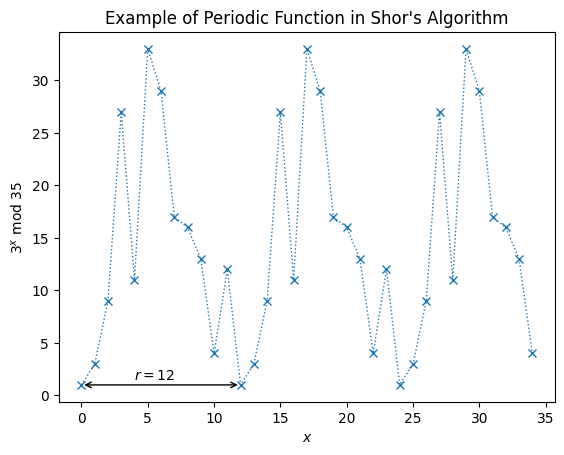

In [208]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## 3. 2. The Solution

Shor’s solution was to use quantum phase estimation on the unitary operator:

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

To see how this is helpful, let’s work out what an eigenstate of U might look like. If we started in the state $|1\rangle$, we can see that each successive application of U will multiply the state of our register by $a \pmod N$, and after $r$ applications we will arrive at the state $|1\rangle$ again. For example with $a = 3$ and $N = 35$:

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle
\end{aligned}$$

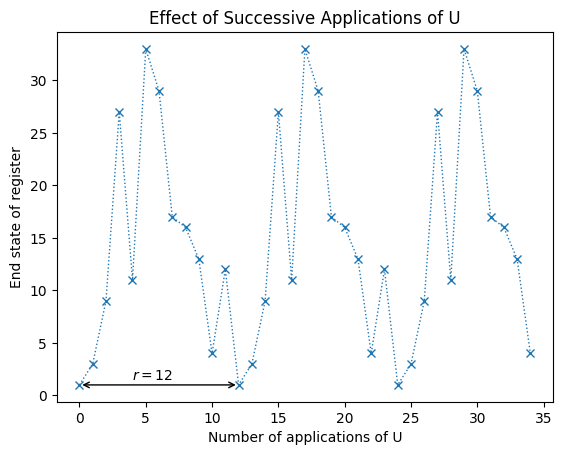

In [209]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

So a superposition of the states in this cycle ($|u_0\rangle$) would be an eigenstate of $U$:

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


This eigenstate has an eigenvalue of 1, which isn’t very interesting. A more interesting eigenstate could be one in which the phase is different for each of these computational basis states. Specifically, let’s look at the case in which the phase of the $k^\text{th}$ state is proportional to $k$:

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(We can see $r = 12$ appears in the denominator of the phase.)
</details>

This is a particularly interesting eigenvalue as it contains $r$. In fact, $r$ has to be included to make sure the phase differences between the $r$ computational basis states are equal. This is not the only eigenstate with this behaviour; to generalise this further, we can multiply an integer, $s$, to this phase difference, which will show up in our eigenvalue:

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle
\end{aligned}
$$

<details>
    <summary>Click to Expand: Example with $a = 3$ and $N=35$</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

We now have a unique eigenstate for each integer value of $s$ where $0 \leq s \leq r-1.$ Very conveniently, if we sum up all these eigenstates, the different phases cancel out all computational basis states except $|1\rangle$:

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>Click to Expand: Example with $a = 7$ and $N=15$</summary>

For this, we will look at a smaller example where $a = 7$ and $N=15$. In this case $r=4$:

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Since the computational basis state $|1\rangle$ is a superposition of these eigenstates, which means if we do QPE on $U$ using the state $|1\rangle$, we will measure a phase:

$$\phi = \frac{s}{r}$$

Where $s$ is a random integer between $0$ and $r-1$. We finally use the [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction) algorithm on $\phi$ to find $r$. The circuit diagram looks like this (note that this diagram uses Qiskit's qubit ordering convention):

![screenshot_1743353306122.png](<https://media-hosting.imagekit.io/4dfb22cd27434537/screenshot_1743353306122.png?Expires=1837961306&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=fHyBu8DpTcvWmgFHRR5QgkZk0W8sEmkhjiC5Vq6V6-2-qKLLM1Vd7NEJFEpKIsWwGWYDW7dT9~IEOgbJbRIj8Uff~jHQMVVHeKMU1z1ImZs4WxZhp6GpN0OshHwwSgXuHZRXIFGJS7iG8P7PzBWcioyfi-JWArFDL5S-NnjxPrjsSvg7GP0LiRCbHWD3oGXOj-It2hsRQvlXPw812rW-HpulucKzgEHXkIFrWPLtlKsweMGGQU6nvKGndVd2DqgmZmmuji~EqRjOdA4-l0m2FGakTrvakNBvHJRgr-HRxL9isbeDP0CJOamOm57IcYfoFQycJfFXZhuxY3bInNIRTg__>)

We will next demonstrate Shor’s algorithm using Qiskit’s simulators. For this demonstration we will provide the circuits for $U$ without explanation, but in section 4 we will discuss how circuits for $U^{2^j}$ can be constructed efficiently.

## 3.3. Qiskit Implementation

In this example we will solve the period finding problem for $a=7$ and $N=15$. We provide the circuits for $U$ where:

$$U|y\rangle = |ay\bmod 15\rangle $$

without explanation. To create $U^x$, we will simply repeat the circuit $x$ times. In the next section we will discuss a general method for creating these circuits efficiently. The function `c_amod15` returns the controlled-U gate for `a`, repeated `power` times.

In [210]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

We will use 8 counting qubits:

In [211]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

We also import the circuit for the QFT (you can read more about the QFT in the [quantum Fourier transform chapter](./quantum-fourier-transform.html#generalqft)):

In [212]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

With these building blocks we can easily construct the circuit for Shor's algorithm:

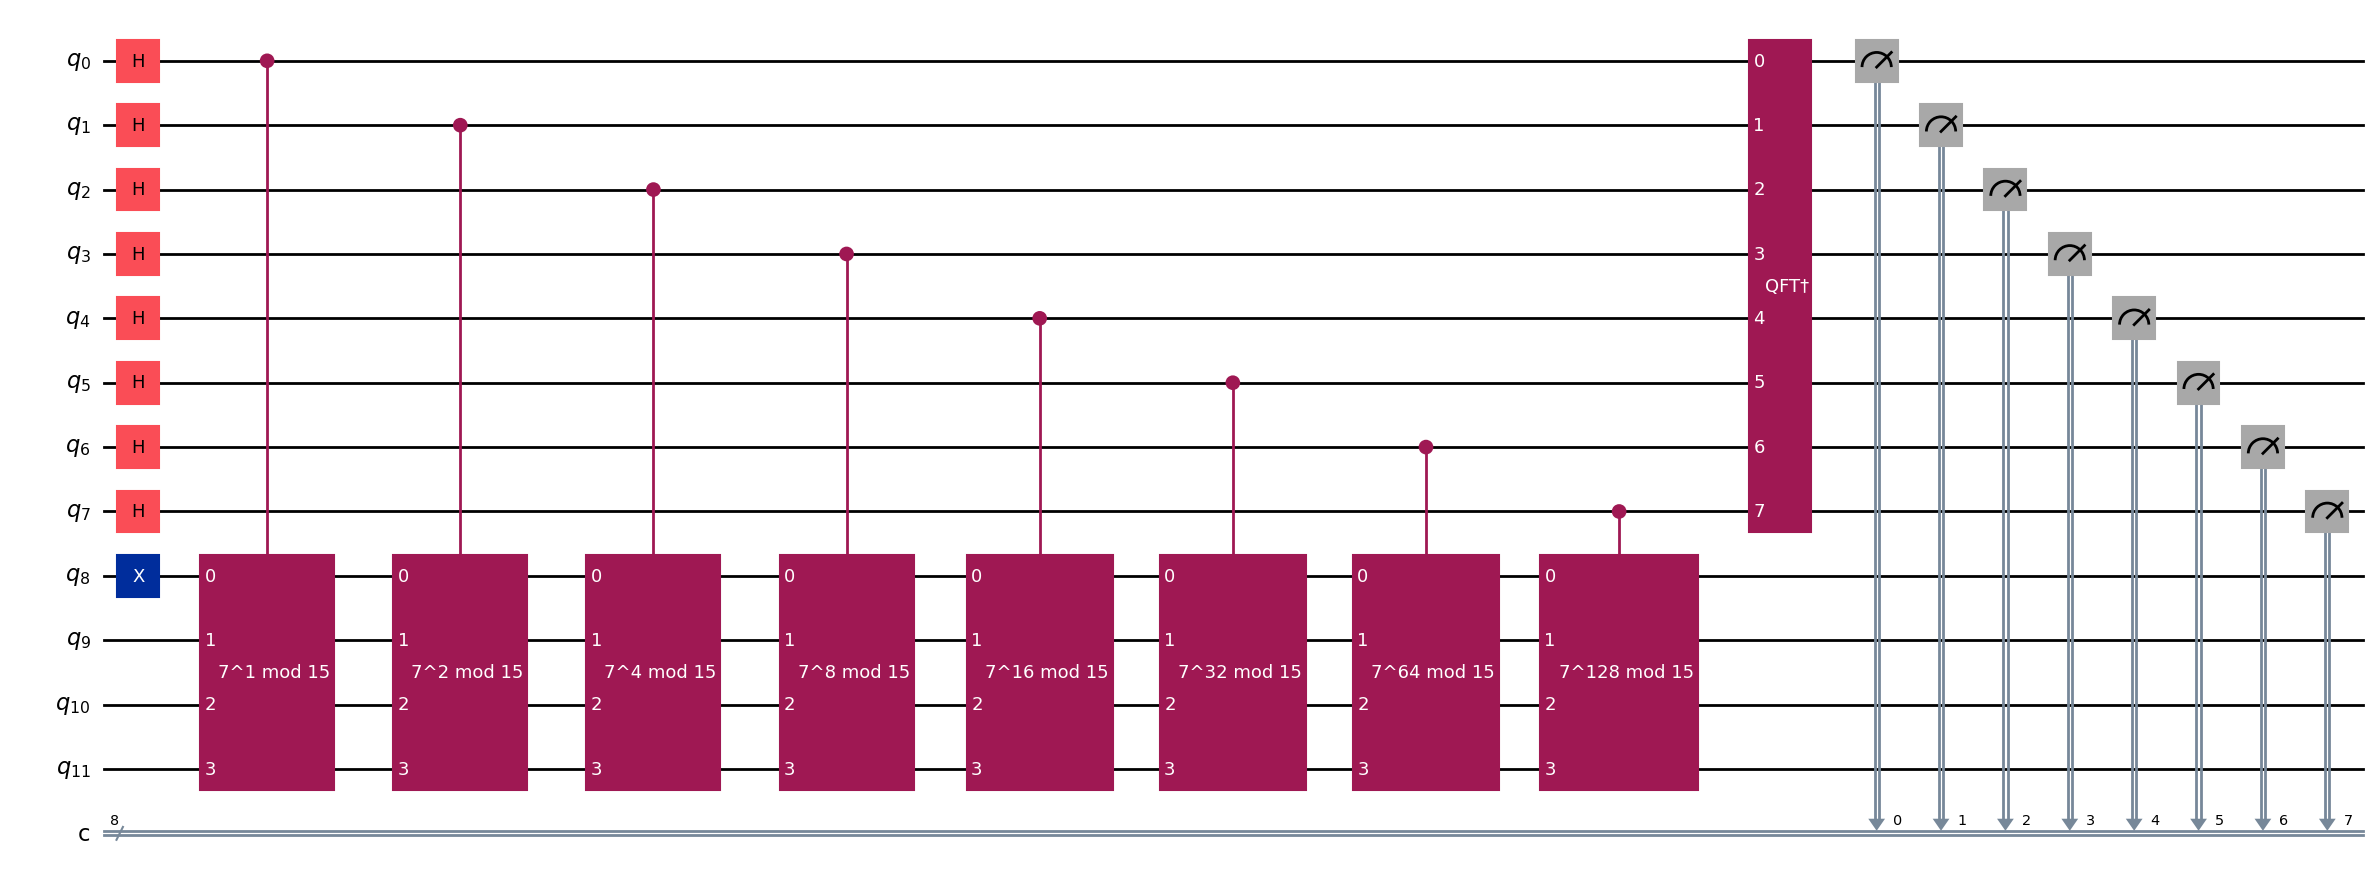

In [213]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1, output = 'mpl')  # -1 means 'do not fold'

Let's see what results we measure:

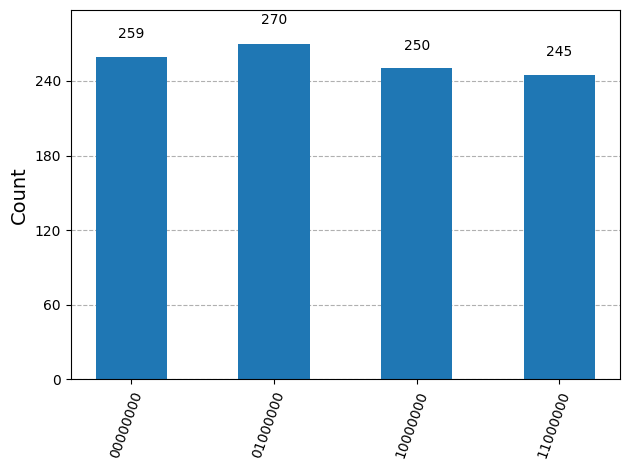

In [214]:
aer_sim = AerSimulator()
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

Since we have 8 qubits, these results correspond to measured phases of:

In [215]:
import pandas as pd
from fractions import Fraction

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  00000000(bin) =   0(dec)    0/256 = 0.00
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  10000000(bin) = 128(dec)  128/256 = 0.50


We can now use the continued fractions algorithm to attempt to find $s$ and $r$. Python has this functionality built in: We can use the `fractions` module to turn a float into a `Fraction` object, for example:

In [216]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Because this gives fractions that return the result exactly (in this case, `0.6660000...`), this can give gnarly results like the one above. We can use the `.limit_denominator()` method to get the fraction that most closely resembles our float, with denominator below a certain value:

In [217]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Much nicer! The order (r) must be less than N, so we will set the maximum denominator to be `15`:

In [218]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.25      1/4            4
3   0.50      1/2            2


We can see that two of the measured eigenvalues provided us with the correct result: $r=4$, and we can see that Shor’s algorithm has a chance of failing. These bad results are because $s = 0$, or because $s$ and $r$ are not coprime and instead of $r$ we are given a factor of $r$. The easiest solution to this is to simply repeat the experiment until we get a satisfying result for $r$.

### Quick Exercise

- Change the circuit above for values of $a = 2, 8, 11$ and $13$. What results do you get and why?

## 3. 4. Modular Exponentiation

You may have noticed that the method of creating the $U^{2^j}$ gates by repeating $U$ grows exponentially with $j$ and will not result in a polynomial time algorithm. We want a way to create the operator:

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

that grows polynomially with $j$. Fortunately, calculating:

$$ a^{2^j} \bmod N$$

efficiently is possible. Classical computers can use an algorithm known as _repeated squaring_ to calculate an exponential. In our case, since we are only dealing with exponentials of the form $2^j$, the repeated squaring algorithm becomes very simple:

In [219]:
from numpy.random import randint

def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [220]:
a2jmodN(7, 2049, 53)

np.int64(47)

If an efficient algorithm is possible in Python, then we can use the same algorithm on a quantum computer. Unfortunately, despite scaling polynomially with $j$, modular exponentiation circuits are not straightforward and are the bottleneck in Shor’s algorithm.

## 3. 5. Factoring from Period Finding

Not all factoring problems are difficult; we can spot an even number instantly and know that one of its factors is 2. In fact, there are specific criteria for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers.

A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form $N = a^b$?), before using Shor’s period finding for the worst-case scenario. Since we aim to focus on the quantum part of the algorithm, we will jump straight to the case in which N is the product of two primes.

### Example: Factoring 15

To see an example of factoring on a small number of qubits, we will factor 15, which we all know is the product of the not-so-large prime numbers 3 and 5.

In [221]:
N = 15

The first step is to choose a random number, $a$, between $1$ and $N-1$:

In [222]:
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


Next we quickly check it isn't already a non-trivial factor of $N$:

In [223]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Great. Next, we do Shor's order finding algorithm for `a = 7` and `N = 15`. Remember that the phase we measure will be $s/r$ where:

$$ a^r \bmod N = 1 $$

and $s$ is a random integer between 0 and $r-1$.

In [224]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

From this phase, we can easily find a guess for $r$:

In [225]:
from qiskit_aer import Aer        # or from qiskit import Aer
from fractions import Fraction

phase = qpe_amod15(a)            # Assume a = 7 or similar
Fraction(phase).limit_denominator(15)


Register Reading: 00000000
Corresponding Phase: 0.0


Fraction(0, 1)

In [226]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


Now we have $r$, we might be able to use this to find a factor of $N$. Since:

$$a^r \bmod N = 1 $$

then:

$$(a^r - 1) \bmod N = 0 $$

which means $N$ must divide $a^r-1$. And if $r$ is also even, then we can write:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(if $r$ is not even, we cannot go further and must try again with a different value for $a$). There is then a high probability that the greatest common divisor of $N$ and either $a^{r/2}-1$, or $a^{r/2}+1$ is a proper factor of $N$ [2]:

In [227]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


The cell below repeats the algorithm until at least one factor of 15 is found. You should try re-running the cell a few times to see how it behaves.

In [228]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [229]:
# The cell below repeats the algorithm until at least one factor of 15
# is found
assert (3 in guesses) or (5 in guesses)

# Tasks

## Task 1: Implement the Inverse QFT

Implement the inverse QFT on an n-qubit register using your existing qft_rotations() logic in reverse.

Steps:
1. Define a function inverse_qft(circuit, n) that:
2. Reverses the qubit order using SWAP gates.
3. Applies the inverse controlled phase rotations and Hadamard gates in the correct order.
4. Test your inverse_qft function by applying QFT followed by inverse QFT to a quantum state and confirming it returns to the original state (e.g., via measurement or statevector fidelity).



In [230]:
def inverse_qft(circuit, n):
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)

    for j in range(n - 1, -1, -1):
        for m in range(j - 1, -1, -1):
            circuit.cp(-np.pi / float(2 ** (j - m)), m, j)
        circuit.h(j)

n_qubits = 4
qc = QuantumCircuit(n_qubits)

qc.x(0)

qft = QFT(n_qubits)
qc.append(qft, range(n_qubits))

inverse_qft(qc, n_qubits)

qc.measure_all()

simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()

counts = result.get_counts(qc)
print(counts)

{'1011': 2, '0010': 5, '1111': 41, '0001': 314, '1101': 29, '0000': 79, '1100': 96, '0110': 76, '1000': 54, '0111': 3, '0011': 61, '1001': 33, '0101': 73, '1110': 56, '1010': 40, '0100': 62}


## Task 2: Apply QFT to a Known Basis State

Demonstrate the effect of QFT on the basis state |5⟩ (binary: 101) using a 3-qubit system.

Steps:
1. Initialize a 3-qubit circuit in state |101⟩ using x() gates.
2. Apply QFT to the circuit.
3. Use Statevector or measurement to observe the transformation into the frequency domain.
4. Optionally, compare this output to the analytical QFT of |5⟩.

In [231]:
qc = QuantumCircuit(3)
qc.x(0)
qc.x(2)

qft = QFT(3)
qc.append(qft, range(3))

simulator = Aer.get_backend('statevector_simulator')

qc_transpiled = transpile(qc, simulator)

result = simulator.run(qc_transpiled).result()
statevector = result.get_statevector()

print("Statevector:")
print(statevector)

qc.measure_all()

qc_transpiled = transpile(qc, simulator)

result = simulator.run(qc_transpiled, shots=1024).result()
counts = result.get_counts()

print("Counts:")
print(counts)

Statevector:
Statevector([ 3.53553391e-01-4.32978028e-17j,
             -3.53553391e-01+4.32978028e-17j,
              6.49467042e-17+3.53553391e-01j,
             -6.49467042e-17-3.53553391e-01j,
             -2.50000000e-01-2.50000000e-01j,
              2.50000000e-01+2.50000000e-01j,
              2.50000000e-01-2.50000000e-01j,
             -2.50000000e-01+2.50000000e-01j],
            dims=(2, 2, 2))
Counts:
{'110': 111, '000': 119, '010': 133, '100': 107, '101': 121, '111': 134, '011': 152, '001': 147}


## Task 3: Estimate Phase Using QPE and QFT

Use QFT to estimate the phase s/r from a controlled-unitary operation (e.g., modular exponentiation $a^{x}$ mod 15).

Steps:
1. Use or modify the provided function qpe_amod15(a) (or build one).
2. Run QPE with a = 7 or a = 11 and extract the estimated phase.
3. Use Python’s Fraction(phase).limit_denominator(15) to approximate the rational value.
4. Interpret s and r from the result and explain what they represent.

In [235]:
def modular_exponentiation(circuit, a, n, control_qubits, target_qubits):
    for i, qubit in enumerate(control_qubits):
        exponent = 2 ** i
        circuit = apply_modular_exponentiation_gate(circuit, a, n, exponent, qubit, target_qubits)
    return circuit

def apply_modular_exponentiation_gate(circuit, a, n, exponent, control_qubit, target_qubits):
    for i in range(exponent):
        circuit.cp(np.pi / float(2**i), control_qubit, target_qubits[i % len(target_qubits)])
    return circuit

def qpe_amod15(a, n=15, num_qubits=4):
    qc = QuantumCircuit(num_qubits + 3, num_qubits)
    for qubit in range(num_qubits):
        qc.h(qubit)
    control_qubits = range(num_qubits)
    target_qubits = range(num_qubits, num_qubits + 3)

    qc = modular_exponentiation(qc, a, n, control_qubits, target_qubits)

    qft = QFT(num_qubits)
    qc.append(qft, control_qubits)

    qc.measure(control_qubits, range(num_qubits))

    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts()

    phase_binary = max(counts, key=counts.get)
    phase_int = int(phase_binary, 2)
    phase = phase_int / 2**num_qubits

    fraction_phase = Fraction(phase).limit_denominator(15)
    return fraction_phase, counts

a = 7
fraction_phase, counts = qpe_amod15(a)
print(f"Estimated phase for a = {a}: {fraction_phase}")
print(f"Measurement counts: {counts}")

Estimated phase for a = 7: 0
Measurement counts: {'0000': 1024}
